**<목차>**

### 1. [info data 일일 집계 결과](#1.-info-data-일일-집계-결과)

### 2. [로그인 플랫폼](#2.-로그인-플랫폼)

### 3. [대회 날짜와 y 관계](#3.-대회-날짜와-y-관계)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.chdir('/content/drive/MyDrive/dacon/daconcup/')
import utils

In [4]:
data = pd.read_csv('/content/drive/MyDrive/dacon/daconcup/Data/raw/train.csv', encoding='cp949')
info_user = pd.read_csv('/content/drive/MyDrive/dacon/daconcup/Data/raw/info_user.csv', encoding='cp949')
info_login = pd.read_csv('/content/drive/MyDrive/dacon/daconcup/Data/raw/info_login.csv', encoding='cp949')
info_cpt = pd.read_csv('/content/drive/MyDrive/dacon/daconcup/Data/raw/info_competition.csv', encoding='cp949')
info_sub = pd.read_csv('/content/drive/MyDrive/dacon/daconcup/Data/raw/info_submission.csv', encoding='cp949')

In [5]:
data['date'] = pd.to_datetime(data['DateTime'].apply(lambda x: x[:10])) # date 변수 생성
df = data.groupby('date')[['사용자', '세션', '신규방문자', '페이지뷰']].sum()
df.columns = ['sum_user', 'sum_sess', 'sum_new', 'sum_views']
df = df.reset_index()

# 1. info data 일일 집계 결과

- 2019-08 이전 데이터에서 submission이 정확하게 집계되지 않은 부분이 너무 많음

- 만약 info 집계 데이터를 새로운 feature로 사용한다면 2019-08이후 데이터를 사용해야 함

In [ ]:
def preprocess(df):
    # date 변수 추출
    df['c_time'] = pd.to_datetime(df['c_time'])
    df['date'] = df['c_time'].dt.date
    
    # missing value 제거
    df = df.dropna(how='all') # 모든 row가 missing value 일 때
    return df

In [ ]:
info_user = preprocess(info_user)
info_login = preprocess(info_login)
info_sub = preprocess(info_sub)

In [ ]:
def check_date(df, title=''):
    import seaborn as sns
    df = df.groupby('date')['date'].count().to_frame(name='count').reset_index()
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df.apply(lambda x: x['date'].strftime('%Y') + '-' + x['date'].strftime('%m'), axis=1)
    df['day'] = df['date'].dt.strftime('%d')

    df_pivot = pd.pivot_table(df, index='year_month', columns='day', values='count')
    fig = plt.figure(figsize=(15, 10))
    sns.heatmap(df_pivot, annot=True, fmt='.0f', cmap='YlGn',  linewidths=.1, linecolor='lightgrey')
    plt.title(f"<{title}>")
    plt.show();

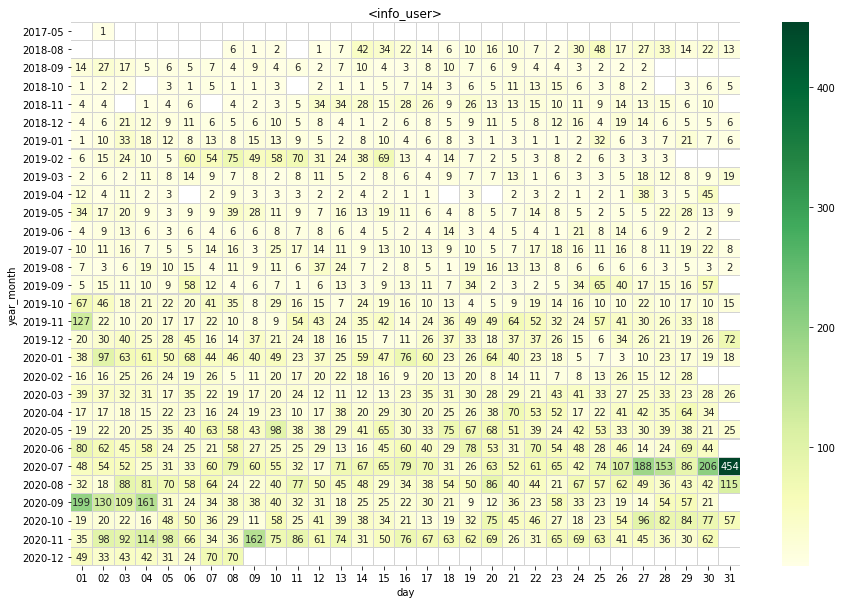

In [ ]:
check_date(info_user, 'info_user') # 빈 날짜는 가입한 회원이 없는 날 -> 0으로 채우기

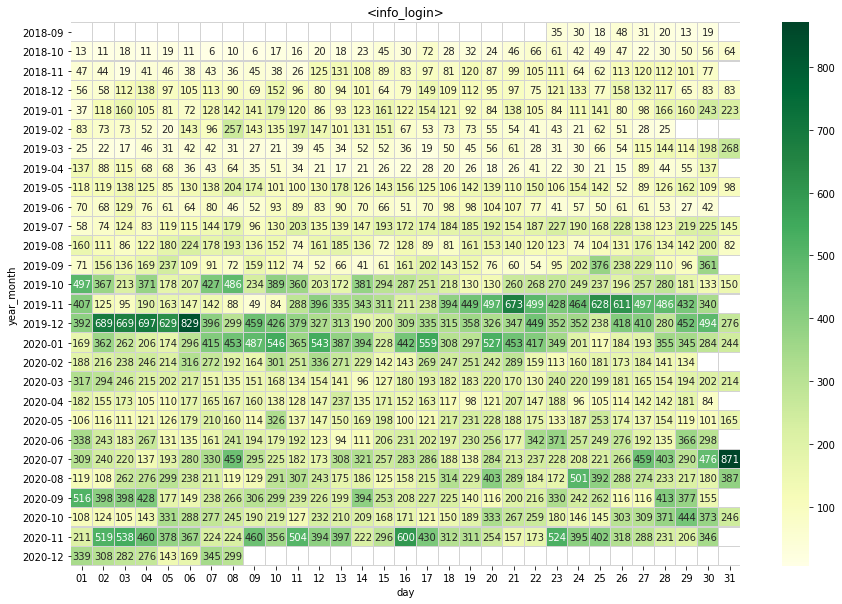

In [ ]:
check_date(info_login, 'info_login') # 빈날짜 없이 꽉 차있음

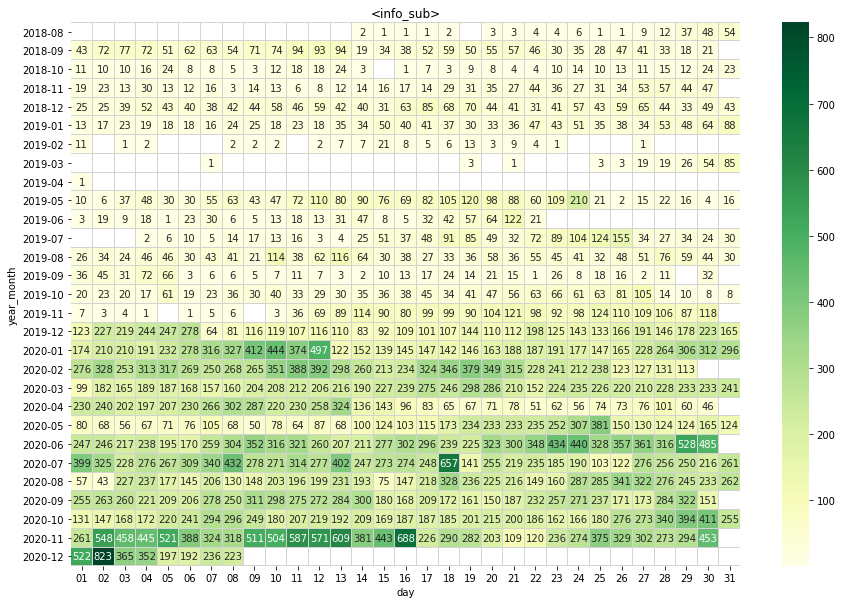

In [ ]:
check_date(info_sub, 'info_sub') # 빈 날짜는 0으로 채우기

2019-08부터 데이터 사용 가능. 이전 데이터에서는 submission이 정확하게 집계되지 않은 부분이 너무 많음.

# 2. 로그인 플랫폼

- 대회 플랫폼 특성상 mobile보다 pc로 접근하는 사용자가 더 많음 

- mobile 사용자를 늘리려면 직접 코드를 실행할 수 없으므로 내부 컨텐츠가 많아져야 함. 따라서 코드 공유나 토론 글이 많아져야 할 듯

In [ ]:
## info_login 
    ## > platform, browser의 NA에 'U' 대입 
info_login['platform'].fillna('unknown', inplace=True)
info_login['platform'] = info_login['platform'].str.replace(r'[^a-zA-Z]','')
info_login['platform'] = info_login['platform'].str.replace(r'XP','')
info_login['browser'].fillna('unknown', inplace=True)
    ## > browser 전처리 
info_login['browser'] = info_login['browser'].str.replace(r'[^a-zA-Z]','')
info_login['browser'] = info_login['browser'].str.replace(r'unknown','')
        ## -> ['InternetExplorer', 'Chrome', 'Opera', 'Safari', 'Firefox', 'iPhone', 'iPad', 'iPadunknown', 'iPhoneunknown', 'Mozilla']

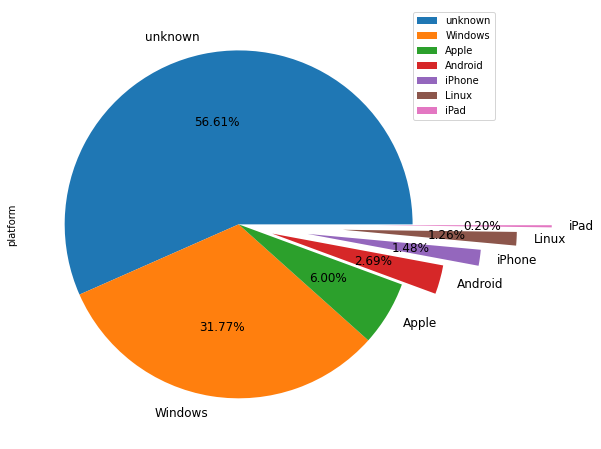

In [ ]:
# 로그인 platform시각화
fig = plt.figure(figsize=(8, 8))
df_for_plot = info_login.platform.value_counts()
explode = (0, 0, 0, 0.2, 0.4, 0.6, 0.8)
df_for_plot.plot(kind='pie', autopct='%.2f%%', fontsize=12, explode=explode)
plt.legend(labels=df_for_plot.index, loc="upperright", bbox_to_anchor=(0.6, 0, 0.5, 1));

- 윈도우 환경이 제일 많고 unknown을 제외한 나머지 결과를 살펴보면, pc가 mobile보다 더 많음

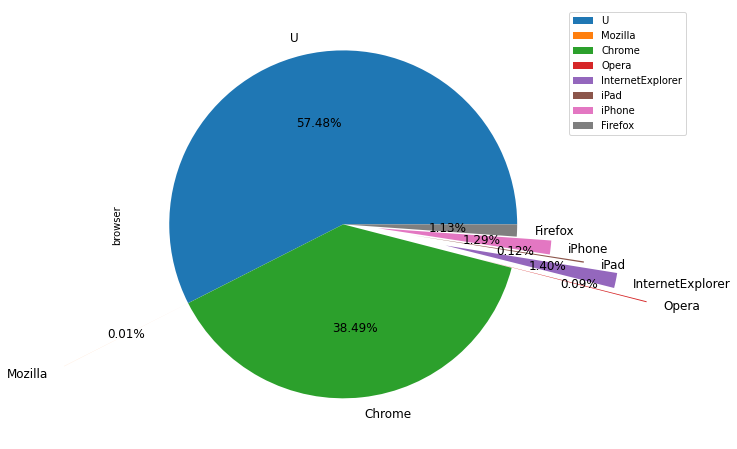

In [ ]:
# 로그인 browser 시각화
cols = ['U', 'Mozilla', 'Chrome', 'Opera', 'InternetExplorer', 'iPad', 'iPhone', 'Firefox']
df_for_browser_plot = info_login.browser.value_counts()[cols]

fig = plt.figure(figsize=(8, 8))
explode = (0, 0.8, 0, 0.8, 0.6, 0.4, 0.2, 0)
df_for_browser_plot.plot(kind='pie', autopct='%.2f%%', fontsize=12, explode=explode)
plt.legend(labels=df_for_browser_plot.index, loc="upperright", bbox_to_anchor=(0.8, 0, 0.5, 1));

- 로그인 브라우저는 크롬이 압도적

# 3. 대회 날짜와 y 관계

- submission 개수와 신규 회원 수는 y와 꽤 높은 선형 관계를 보임(상관계수 0.7이상)

- 추가 분석 필요
    
    - 대회 마감 날짜가 y값에 영향을 주는지

In [ ]:
# category 변수 -> str로 바꾸기 
info_user['id'] = info_user['id'].apply(lambda x: str(x))
info_user['python_level'] = info_user['python_level'].apply(lambda x: str(x))
info_user['ds_level'] = info_user['ds_level'].apply(lambda x: str(x))
info_user['country_code'] = info_user['country_code'].apply(lambda x: str(x))

info_login['login_id'] = info_login['login_id'].apply(lambda x: str(x))
info_login['user_id'] = info_login['user_id'].apply(lambda x: str(x)) 

info_sub['sub_id'] = info_sub['sub_id'].apply(lambda x: str(x))
info_sub['cpt_id'] = info_sub['cpt_id'].apply(lambda x: str(x))
info_sub['team_id'] = info_sub['team_id'].apply(lambda x: str(x))
info_sub['user_id'] = info_sub['user_id'].apply(lambda x: str(x))

In [ ]:
# 일자별 데이터 생성
info_login_day = info_login.groupby('date')['date'].count().to_frame(name='cnt_login').reset_index()
info_user_day = info_user.groupby('date')['date'].count().to_frame(name='cnt_new_user').reset_index()
info_sub_day = info_sub.groupby('date')['date'].count().to_frame(name='cnt_sub').reset_index()

info_day = info_login_day.merge(info_user_day, how='left')
info_day = info_day.merge(info_sub_day, how='left')
info_day.fillna(0, inplace=True)

In [ ]:
info_day

,date,cnt_login,cnt_new_user,cnt_sub
0,2018-09-23,35,4.0,30.0
1,2018-09-24,30,3.0,35.0
2,2018-09-25,18,2.0,28.0
3,2018-09-26,48,2.0,47.0
4,2018-09-27,31,2.0,41.0
...,...,...,...,...
803,2020-12-04,276,42.0,352.0
804,2020-12-05,143,31.0,197.0
805,2020-12-06,169,24.0,192.0
806,2020-12-07,345,70.0,236.0


In [ ]:
info_cpt['period_start'] = pd.to_datetime(info_cpt['period_start'])
info_cpt['period_end'] = pd.to_datetime(info_cpt['period_end'])
info_cpt['start_date'] = info_cpt['period_start'].dt.date
info_cpt['start_date'] = pd.to_datetime(info_cpt['start_date'])
info_cpt['end_date'] = info_cpt['period_end'].dt.date
info_cpt['end_date'] = pd.to_datetime(info_cpt['end_date'])

In [ ]:
df = data.groupby('date')[['사용자', '세션', '신규방문자', '페이지뷰']].sum()
df.columns = ['sum_user', 'sum_sess', 'sum_new', 'sum_views']
df = df.reset_index()
info_day['date'] = pd.to_datetime(info_day['date'])
df = df.merge(info_day, on='date', how='left')
df.dropna(inplace=True)

fig = make_subplots(shared_xaxes=True,rows=7, cols=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_user'], name='# of users'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_sess'], name='# of sessions'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_new'], name='# of new_viewers'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_views'], name='# of page views'), row=4, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['cnt_new_user'], name='회원가입 수'), row=5, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['cnt_login'], name='로그인 수'), row=6, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['cnt_sub'], name='submission 수'), row=7, col=1)
fig.update_layout(autosize=False, width=1500, height=1000,
                  title={
                        'text': "대회 start_date 사용",
                        'xanchor': 'center',
                        'yanchor': 'top'})

ys = ['sum_user', 'sum_sess', 'sum_new', 'sum_views', 'cnt_new_user', 'cnt_login', 'cnt_sub']

for day in info_cpt.start_date.astype(str).tolist():
    for i in range(1, 8):
        fig.add_shape(dict(
                            type="line",
                            x0=pd.to_datetime(day),
                            y0=0,
                            x1=pd.to_datetime(day),
                            y1=max(df[ys[i-1]]),
                            line=dict(
                                color="black",
                                width=1,
                                dash='dashdot'
                    )), row=i, col=1)
fig.show();

가설 : 제출 마감이 얼마 안 남았을 때 submission이 많음. -> 접속자가 많음(session, page views 증가 예상) -> 맞는 것으로 보임 -> 최 추가 분석

In [ ]:
fig = make_subplots(shared_xaxes=True,rows=7, cols=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_user'], name='# of users'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_sess'], name='# of sessions'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_new'], name='# of new_viewers'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['sum_views'], name='# of page views'), row=4, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['cnt_new_user'], name='회원가입 수'), row=5, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['cnt_login'], name='로그인 수'), row=6, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['cnt_sub'], name='submission 수'), row=7, col=1)
fig.update_layout(autosize=False, width=1500, height=1000,
                  title={
                        'text': "대회 end_date 사용",
                        'xanchor': 'center',
                        'yanchor': 'top'})

ys = ['sum_user', 'sum_sess', 'sum_new', 'sum_views', 'cnt_new_user', 'cnt_login', 'cnt_sub']

for day in info_cpt.end_date.astype(str).tolist():
    for i in range(1, 8):
        fig.add_shape(dict(
                            type="line",
                            x0=pd.to_datetime(day),
                            y0=0,
                            x1=pd.to_datetime(day),
                            y1=max(df[ys[i-1]]),
                            line=dict(
                                color="black",
                                width=1,
                                dash='dashdot'
                    )), row=i, col=1)
fig.show();

대회 마감 직전에 submission 수가 많은 것으로 판단됨.

1. submission과 y의 상관관계 확인
 
2. 대회 중에 어떤 대회가 submission에 영향을 미치는지 파악하고, submission에 영향을 미치는 대회의 마감 기한이 얼마 남았는지에 대한 변수를 잡고 y의 분포가 달라지는지 확인하기.

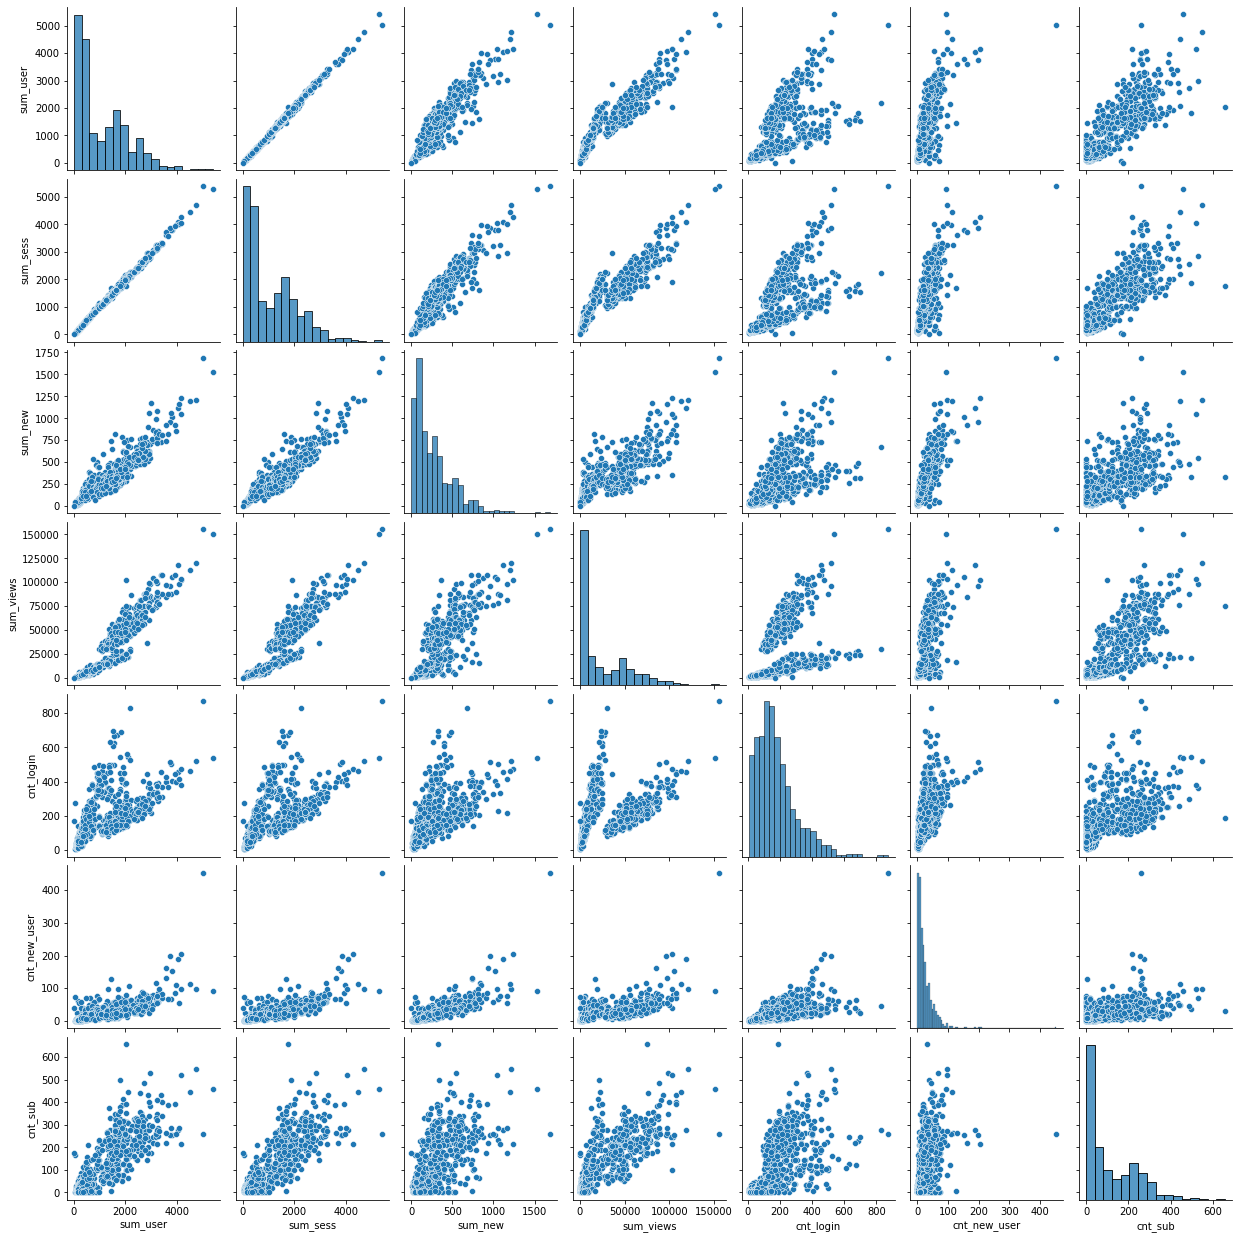

In [ ]:
sns.pairplot(df);

- 맨 아래줄 or 맨 오르쪽 줄에서 submission 수와 y의 상관관계를 살펴볼 수 있음

- sumission수와 y가 선형 관계를 나타내는 것을 알 수 있음. 아래에서 상관 계수를 자세히 살펴보자

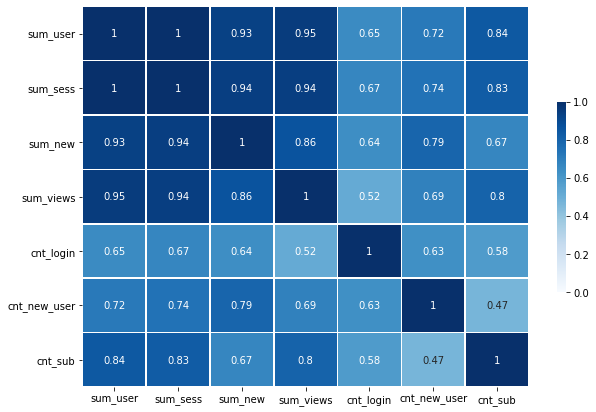

In [ ]:
fig, ax = plt.subplots( figsize=(10,7) )

sns.heatmap(df.corr(), 
            cmap='Blues', 
            annot = True,   # 실제 값을 표시한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = 0,vmax = 1   # 컬러바 범위
           ) ;

- y와 cnt_sub는 꽤 큰 약 0.7 이상의 상관관계를 보임

- 즉, 만약 대회 마감 날짜에 따라서 submission이 달라짐 -> 그에 따른 y값도 달라짐 -> 대회 마감날짜 관련 변수를 추가할 수 있음

- 대회 마감 몇일 남았는지 변수를 만들어서 날짜 범위로 묶어 분포를 확인할 수 있을 듯